# Pseudoknot examples

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set current dir to the rinalmo path
project_path = 'DNALM_dependencies'
os.chdir(os.path.join(project_path, 'RiNALMo'))

In [2]:
import torch
from rinalmo.pretrained import get_pretrained_model

device = "cuda:0"


In [3]:

model, alphabet = get_pretrained_model(model_name="giga-v1")
model = model.to(device=device)
model.eval()
seqs = ["ACUUUGGCCA", "CCCGGU", "ACGU"]

tokens = torch.tensor(alphabet.batch_tokenize(seqs), dtype=torch.int64, device=device)

In [4]:
nuc_table = {"A" : 0, "C":1, "G":2, "U":3} # For RINALMo we have Us instead of Ts

def mutate_sequence(seq):
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]} #,'gene_id': []}
    #mutated_sequences['gene_id'].append(gene_id)
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'U']:
            if nuc != seq[i]:
                #mutated_sequences['gene_id'].append(gene_id)
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNADataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

def custom_collate_fn(batch):

    # batch is a list of sequences
    tokenized_batch = torch.tensor(alphabet.batch_tokenize(batch), 
                                   dtype=torch.int64, 
                                   device=device)
    return tokenized_batch

batch_size = 64

def create_dataloader(dataset, batch_size=batch_size):
    rna_dataset = RNADataset(list(dataset['seq'].values))
    data_loader = DataLoader(rna_dataset, 
                            batch_size=batch_size, 
                            shuffle=False,
                            collate_fn=custom_collate_fn)
    return data_loader

In [6]:
acgu_idxs = [5, 6, 7, 8]
def model_inference(model, data_loader):

    print(f'Inferencing {len(data_loader)} batches')
    output_arrays = []
    for i, batch_tokens in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(batch_tokens)['logits'].cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgu_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    print(f'Inferencing done')

    # rebuild to nseqs, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

In [7]:
def compute_ci_matrix(gene_seq,  get_logit=True, effect_on_ref_only = False):

    dataset = mutate_sequence(gene_seq) 
    data_loader = create_dataloader(dataset)
    snp_reconstruct = model_inference(model, data_loader)
    snp_reconstruct = snp_reconstruct[:,1:-1,:] # discard the beginning of sentence token and end of sentence token
    print(snp_reconstruct.shape)

    non_zero_log_value = 1e-10 #due to the conversion to bfloat16, we need to add a small value to avoid log(0)

    if get_logit: # for the logit add the small value and renormalize such that every prob in one position sums to 1
        snp_reconstruct = snp_reconstruct + non_zero_log_value
        snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    print('shape of the reference probs:', reference_probs.shape)

    if get_logit:
        snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
            - np.log2(reference_probs) + np.log2(1-reference_probs)
    else:
        snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]+non_zero_log_value) - np.log2(reference_probs+non_zero_log_value)

    if effect_on_ref_only:
        gene_seq_int = dataset.iloc[1:].groupby('mutation_pos').apply(lambda pos_df: (set(range(4)) - set(pos_df['var_nt_idx'])).pop()).values
        snp_effect_on_ref = snp_effect[:,np.arange(seq_len),:, gene_seq_int]
        ci_matrix = np.max(np.abs(snp_effect_on_ref), axis=2)

    else:
        ci_matrix = np.max(np.abs(snp_effect), axis=(2,3))

    return ci_matrix

def plot_ci_matrix(ci_matrix, vmax=None, figsize=[10, 10]):#increase figure size
    plt.rcParams['figure.figsize'] = figsize
    plt.imshow(ci_matrix, cmap="coolwarm", vmax=vmax) if vmax is not None else plt.imshow(ci_matrix, cmap="coolwarm")
    return plt

In [8]:
import seaborn as sns
#plot_size = 50
#na_seq = RNA
tick_label_fontsize = 4

def plot_w_seq(ci_matrix, dna_seq, plot_size = 10, tick_label_fontsize = 4, filename=None, savefig=False, dpi=300, vmax=5):
    print(f"Sequence length: {len(dna_seq)}")
    plt.figure(figsize=(plot_size, plot_size))
    sns.heatmap(ci_matrix, cmap='coolwarm', vmax=vmax,  cbar=False)

    plt.gca().set_aspect('equal')

    tick_positions = np.arange(len(dna_seq)) + 0.5
    plt.xticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    plt.yticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)

    if savefig:
        plt.savefig(filename, dpi=dpi, bbox_inches='tight')

    plt.show()

### Get probs

In [9]:
# get a df with 'gene_id': [], 'seq':[], 'mask_pos':[] by masking each position in the gene_seq. 
#'seq' will contain the sequence with the masked position, 'mask_pos' will contain the position of the masked nucleotide

mask_token = "<mask>"
def get_masked_sequence_df(seq):

    seq = seq.upper()
    seq = list(seq)
    masked_seq = []
    mask_pos = []

    #append ref sequence
    masked_seq.append(" ".join(seq))
    mask_pos.append(-1)

    for i in range(len(seq)):
        masked_seq.append(" ".join((seq[:i] + [mask_token] + seq[i+1:])))
        mask_pos.append(i)

    return pd.DataFrame({'seq': masked_seq, 'mask_pos': mask_pos})

In [10]:
acgu_idxs = [5, 6, 7, 8]
def model_inference_probs(seq, batch_size=32):

    tokens = torch.tensor(alphabet.batch_tokenize([seq]), dtype=torch.int64, device=device)
    tokens_mat = tokens.repeat(tokens.shape[1], 1)
    tokens_mat[range(1,tokens_mat.shape[1]-1), range(1,tokens_mat.shape[1]-1)] = alphabet.tkn_to_idx[mask_token] #fill diagonal except the start and stop tokens
    batches_tokens_mat = tokens_mat.split(batch_size)
    print(f'Inferencing {len(batches_tokens_mat)} batches')

    output_arrays = []
    for i, batch_tokens in enumerate(batches_tokens_mat):
        # get some tokenized sequences (B, L_in)
        
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(batch_tokens)['logits'].cpu().to(torch.float32)

        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgu_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    print(f'Inferencing done')

    # rebuild to nseqs, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)
    snp_reconstruct = snp_reconstruct.to(torch.float32).numpy()
    
    return snp_reconstruct[range(1,tokens_mat.shape[1]-1), range(1,tokens_mat.shape[1]-1),:] # get probs for masked positions

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(
            matplotlib.patches.Polygon(
                (np.array([1,height])[None,:]*polygon_coords
                 + np.array([left_edge,base])[None,:]),
                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.825, base+0.085*height],
        width=0.174, height=0.415*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.625, base+0.35*height],
        width=0.374, height=0.15*height,
        facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
        width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
        width=1.0, height=0.2*height, facecolor=color,
        edgecolor=color, fill=True))

    
def plot_u(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.95, height=0.8*height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.025, base+0.4*height], width=0.95, height=0.6*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.6175, height=0.52*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.19125, base+0.4*height], width=0.6175, height=0.6*height,
        facecolor='white', edgecolor='white', fill=True))
    """ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))"""
    

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}


def plot_weights_given_ax(ax, array,          
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.show()
    
    
def dna_plot_weights(array, **kwargs):
  plot_weights(array=array, plot_funcs=dna_plot_funcs, **kwargs)


def rna_plot_weights(array, **kwargs):
  plot_weights(array=array, plot_funcs=rna_plot_funcs, **kwargs)

In [12]:
def compute_log_ratio(nuc_probs):
    nucs_mean = nuc_probs[:-3].mean(axis = 0)
    nucs_normed = nuc_probs * np.log2(nuc_probs/nucs_mean)
    return nucs_normed

In [13]:
import matplotlib.gridspec as gridspec
def combined_plot(probs, ci_matrix, sequence, figsize=(15, 16), tick_label_fontsize=10, vmax=10, savefig=False, filename=None, dpi=300, show_plot=True):
    # Set up the figure and subplots
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[12, 1])  # Adjust height ratios based on visual needs

    # First subplot for the matrix
    ax1 = fig.add_subplot(gs[0])
    sns.heatmap(ci_matrix, cmap='coolwarm', vmax=vmax, cbar=False, ax=ax1)
    seq_len = len(sequence)
    ax1.set_xlim(0, seq_len)

    # Second subplot for the sequence weights
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    plot_weights_given_ax(ax=ax2, array=compute_log_ratio(probs), subticks_frequency=1)
    ax2.set_xticks([])  # Hide x-tick labels on the sequence plot

    # Aligning ticks
    tick_positions = np.arange(seq_len) + 0.5
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(list(sequence), fontsize=tick_label_fontsize, rotation=0)
    ax1.set_yticks(tick_positions)
    ax1.set_yticklabels(list(sequence), fontsize=tick_label_fontsize, rotation=0)

    plt.subplots_adjust(hspace=0)

    if savefig:
        plt.savefig(filename, dpi=dpi, bbox_inches='tight')

    if show_plot:
        plt.show()

## Riboswitch TPP

In [32]:

RNA_seq = '''CCAAACGACUCGGGGUGCCCUUCUGCGUGAAGGCUGAGAAAUACCCGUAUCACCUGAUCUGGAUAAUGCCAGCGUAGGGAAGUCACGGACCACCAGG'''.replace('\n', '')
RNA_seq

'CCAAACGACUCGGGGUGCCCUUCUGCGUGAAGGCUGAGAAAUACCCGUAUCACCUGAUCUGGAUAAUGCCAGCGUAGGGAAGUCACGGACCACCAGG'

In [33]:
ci_matrix = compute_ci_matrix(RNA_seq)
ci_matrix

Inferencing 5 batches
Inferencing done
(292, 97, 4)
shape of the reference probs: (97, 4)


array([[4.45478106, 0.47411591, 0.16378799, ..., 0.08709933, 0.28859401,
        0.19016099],
       [0.68264306, 4.41614056, 0.79915059, ..., 0.23346712, 0.3242861 ,
        0.14137959],
       [0.2872282 , 0.79728913, 4.3344779 , ..., 0.33076215, 0.27896667,
        0.10736537],
       ...,
       [0.12710303, 0.14270759, 0.23037773, ..., 4.1724124 , 1.44676876,
        0.37694764],
       [0.24595395, 0.16568582, 0.10801218, ..., 0.99083596, 3.83944798,
        0.76090306],
       [0.33039537, 0.16955662, 0.12374948, ..., 0.40169376, 0.56586212,
        4.10975313]])

In [29]:
dot_brack = '.....(((((((((.((((((........))).)).......)..)))).....((((..((((......))))..))))...)))))............'

In [30]:
def create_contact_matrix(structure):
    stack = []
    matrix_size = len(structure)
    contact_matrix = torch.zeros((matrix_size, matrix_size), dtype=int)

    for i, char in enumerate(structure):
        if char == '(':
            stack.append(i)
        elif char == ')' and stack:
            j = stack.pop()
            contact_matrix[i,j] = contact_matrix[j,i] = 1

    return contact_matrix

Sequence length: 100


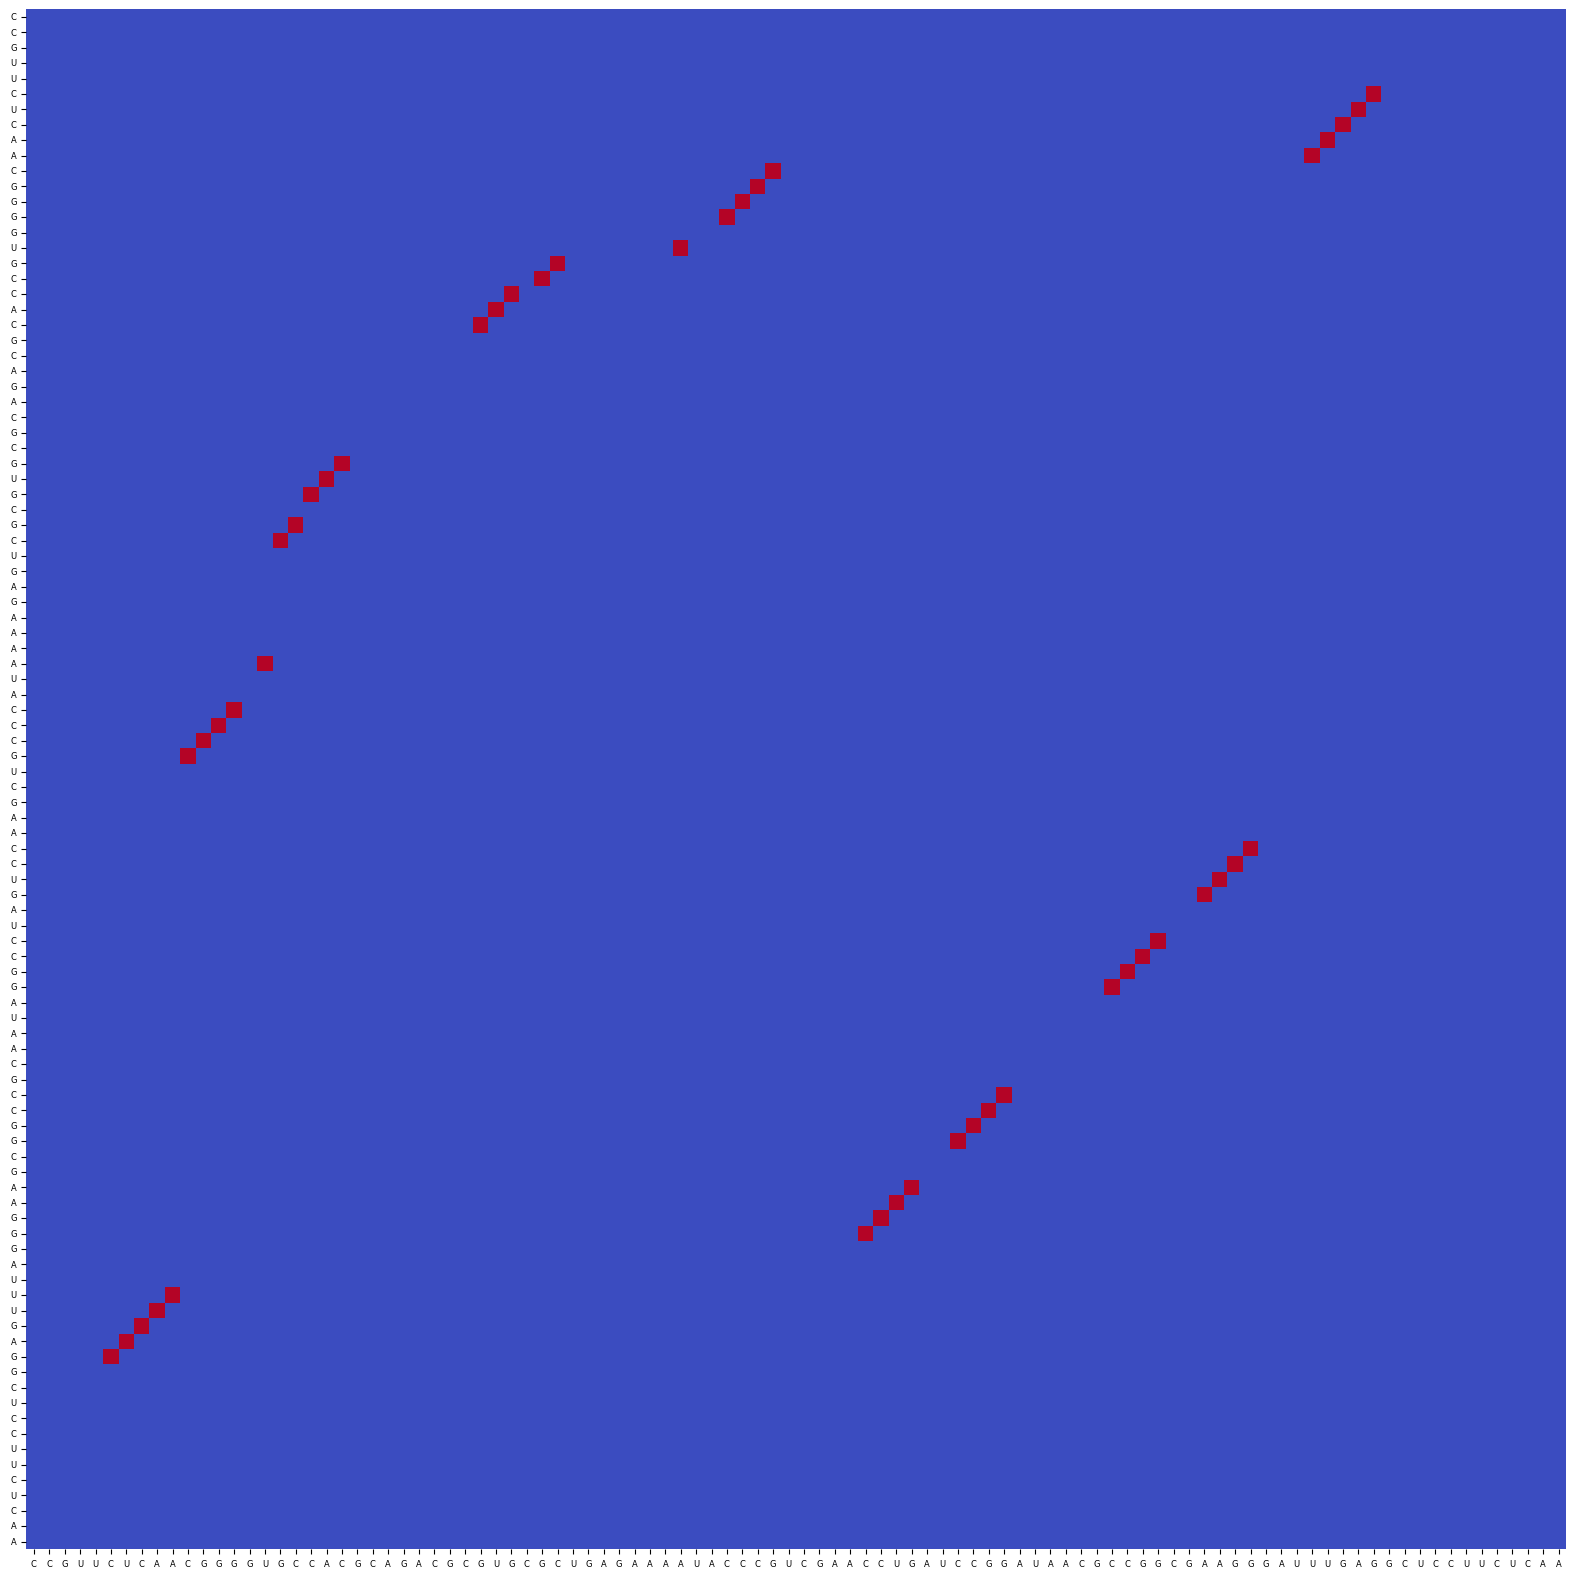

In [31]:
contact_map = create_contact_matrix(dot_brack)
plot_w_seq(contact_map, RNA_seq, vmax=1, plot_size=20, tick_label_fontsize=6)

Sequence length: 97


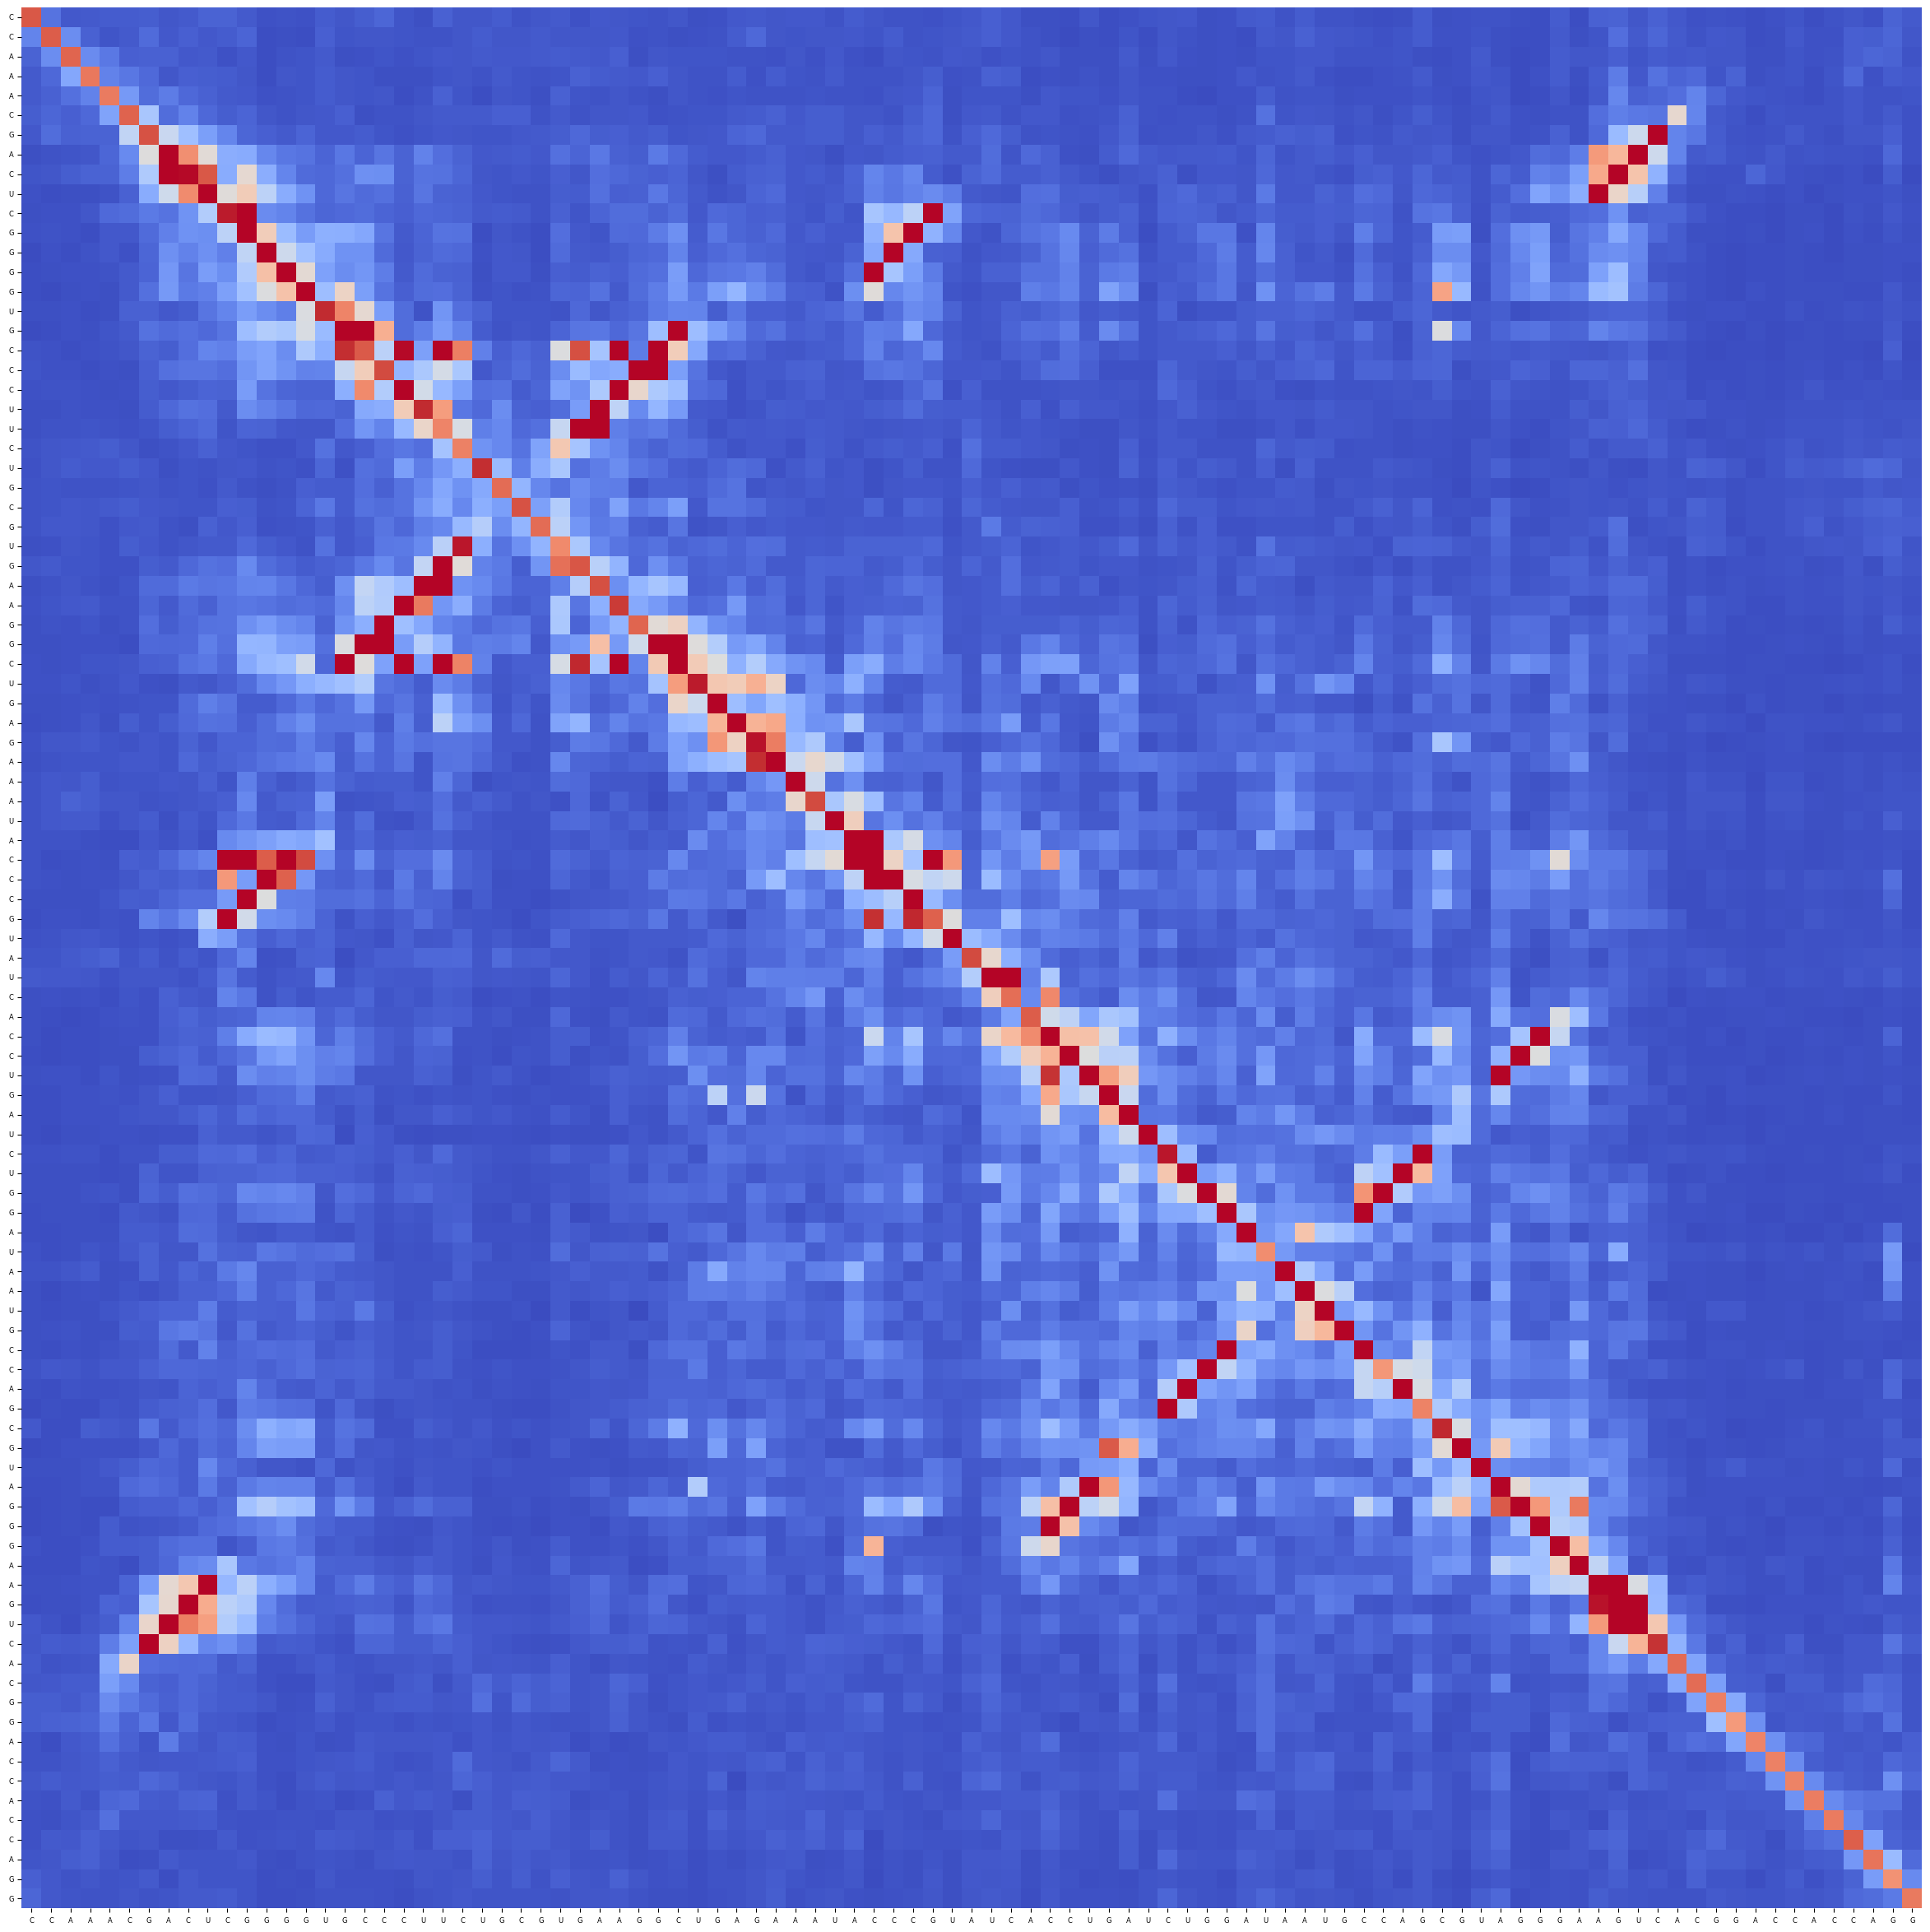

In [34]:
plot_w_seq(ci_matrix, RNA_seq, plot_size=30, tick_label_fontsize=6, filename=None, savefig=False)

## RNAseP

## Bacillus subtilis subsp. subtilis str. 168

In [90]:
#RFAM Bacterial RNase P class B (RF00011) -  Bacillus subtilis subsp. subtilis str. 168 RNA component of ribonuclease P (RNase P) (catalytic subunit, ribozyme)
RNA_seq = '''CUUAACGUUCGGGUAAUCGCUGCAGAUCUUGAAUCUGUAGAGGAAAGUCCAUGCUCGCACGGUGCUGAGAUGCCCGUAGU
GUUCGUGCCUAGCGAAGUCAUAAGCUAGGGCAGUCUUUAGAGGCUGACGGCAGGAAAAAAGCCUACGUCUUCGGAUAUGG
CUGAGUAUCCUUGAAAGUGCCACAGUGACGAAGUCUCACUAGAAAUGGUGAGAGUGGAACGCGGUAAACCCCUCGAGCGA
GAAACCCAAAUUUUGGUAGGGGAACCUUCUUAACGGAAUUCAACGGAGAGAAGGACAGAAUGCUUUCUGUAGAUAGAUGA
UUGCCGCCUGAGUACGAGGUGAUGAGCCGUUUGCAGUACGAUGGAACAAAACAUGGCUUACAGAACGUUAGACCAC'''.replace('\n', '')
RNA_seq

'CUUAACGUUCGGGUAAUCGCUGCAGAUCUUGAAUCUGUAGAGGAAAGUCCAUGCUCGCACGGUGCUGAGAUGCCCGUAGUGUUCGUGCCUAGCGAAGUCAUAAGCUAGGGCAGUCUUUAGAGGCUGACGGCAGGAAAAAAGCCUACGUCUUCGGAUAUGGCUGAGUAUCCUUGAAAGUGCCACAGUGACGAAGUCUCACUAGAAAUGGUGAGAGUGGAACGCGGUAAACCCCUCGAGCGAGAAACCCAAAUUUUGGUAGGGGAACCUUCUUAACGGAAUUCAACGGAGAGAAGGACAGAAUGCUUUCUGUAGAUAGAUGAUUGCCGCCUGAGUACGAGGUGAUGAGCCGUUUGCAGUACGAUGGAACAAAACAUGGCUUACAGAACGUUAGACCAC'

In [91]:
len(RNA_seq)

396

In [92]:
ci_matrix = compute_ci_matrix(RNA_seq)
ci_matrix

Inferencing 19 batches
Inferencing done
(1189, 396, 4)
shape of the reference probs: (396, 4)


array([[4.78469896, 2.08778024, 1.52219486, ..., 0.1103216 , 0.0737679 ,
        0.12717575],
       [2.57744789, 4.47638321, 2.61349869, ..., 0.06532209, 0.10782313,
        0.0927052 ],
       [1.94144928, 2.86806226, 4.60613966, ..., 0.08809417, 0.06871343,
        0.10389238],
       ...,
       [0.54216647, 0.40760109, 0.33156252, ..., 4.69239235, 1.4766736 ,
        0.83311725],
       [0.17349161, 0.12797144, 0.30913225, ..., 1.47985733, 4.22468424,
        1.85849953],
       [0.17230882, 0.10718724, 0.27809587, ..., 0.87680918, 1.64073539,
        4.38168621]])

In [93]:
dot_brack = '(.((((((((((((((((.(((((((((...))))))))).............(((((((((.((......)))))).....(((((((((((..........))))))((((((......))))).)((.(((.(..((((((..((((..))))).)))))...).))).....(((((............((((((((....)))))))).........)))..))))))))))))))...(((.(.......).)))...((((((((((((.(...)))))))))))))((((((.().))))))........)))))))(((((.((((..(((.....))).......)))).)))))...............).))))))))).....'

In [94]:
def create_contact_matrix(structure):
    stack = []
    matrix_size = len(structure)
    contact_matrix = torch.zeros((matrix_size, matrix_size), dtype=int)

    for i, char in enumerate(structure):
        if char == '(':
            stack.append(i)
        elif char == ')' and stack:
            j = stack.pop()
            contact_matrix[i,j] = contact_matrix[j,i] = 1

    return contact_matrix

Sequence length: 396


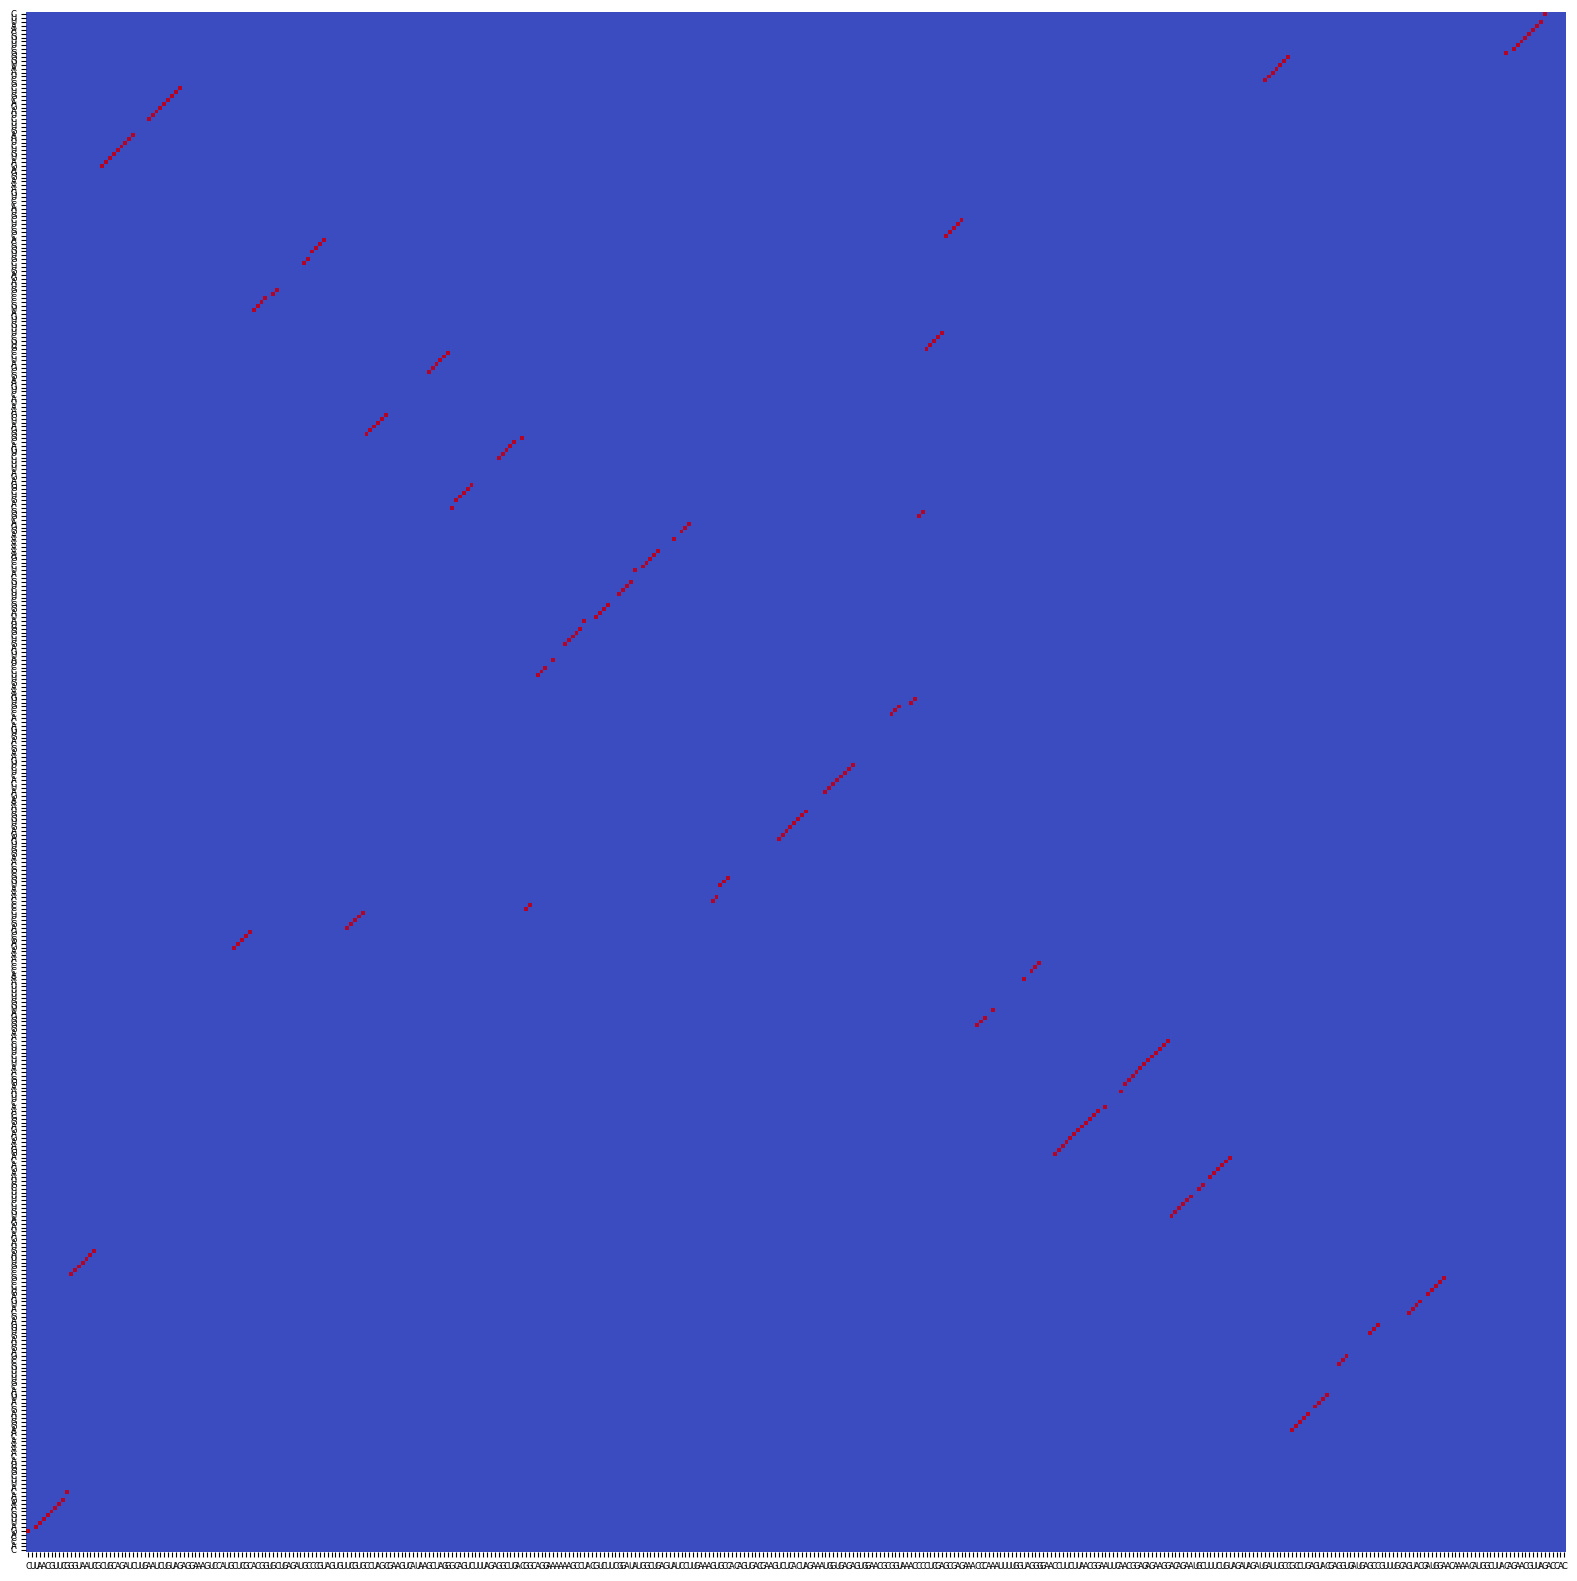

In [95]:
contact_map = create_contact_matrix(dot_brack)
plot_w_seq(contact_map, RNA_seq, vmax=1, plot_size=20, tick_label_fontsize=6)

In [96]:
ci_matrix[np.arange(ci_matrix.shape[0]), np.arange(ci_matrix.shape[1])] = 0

Sequence length: 396


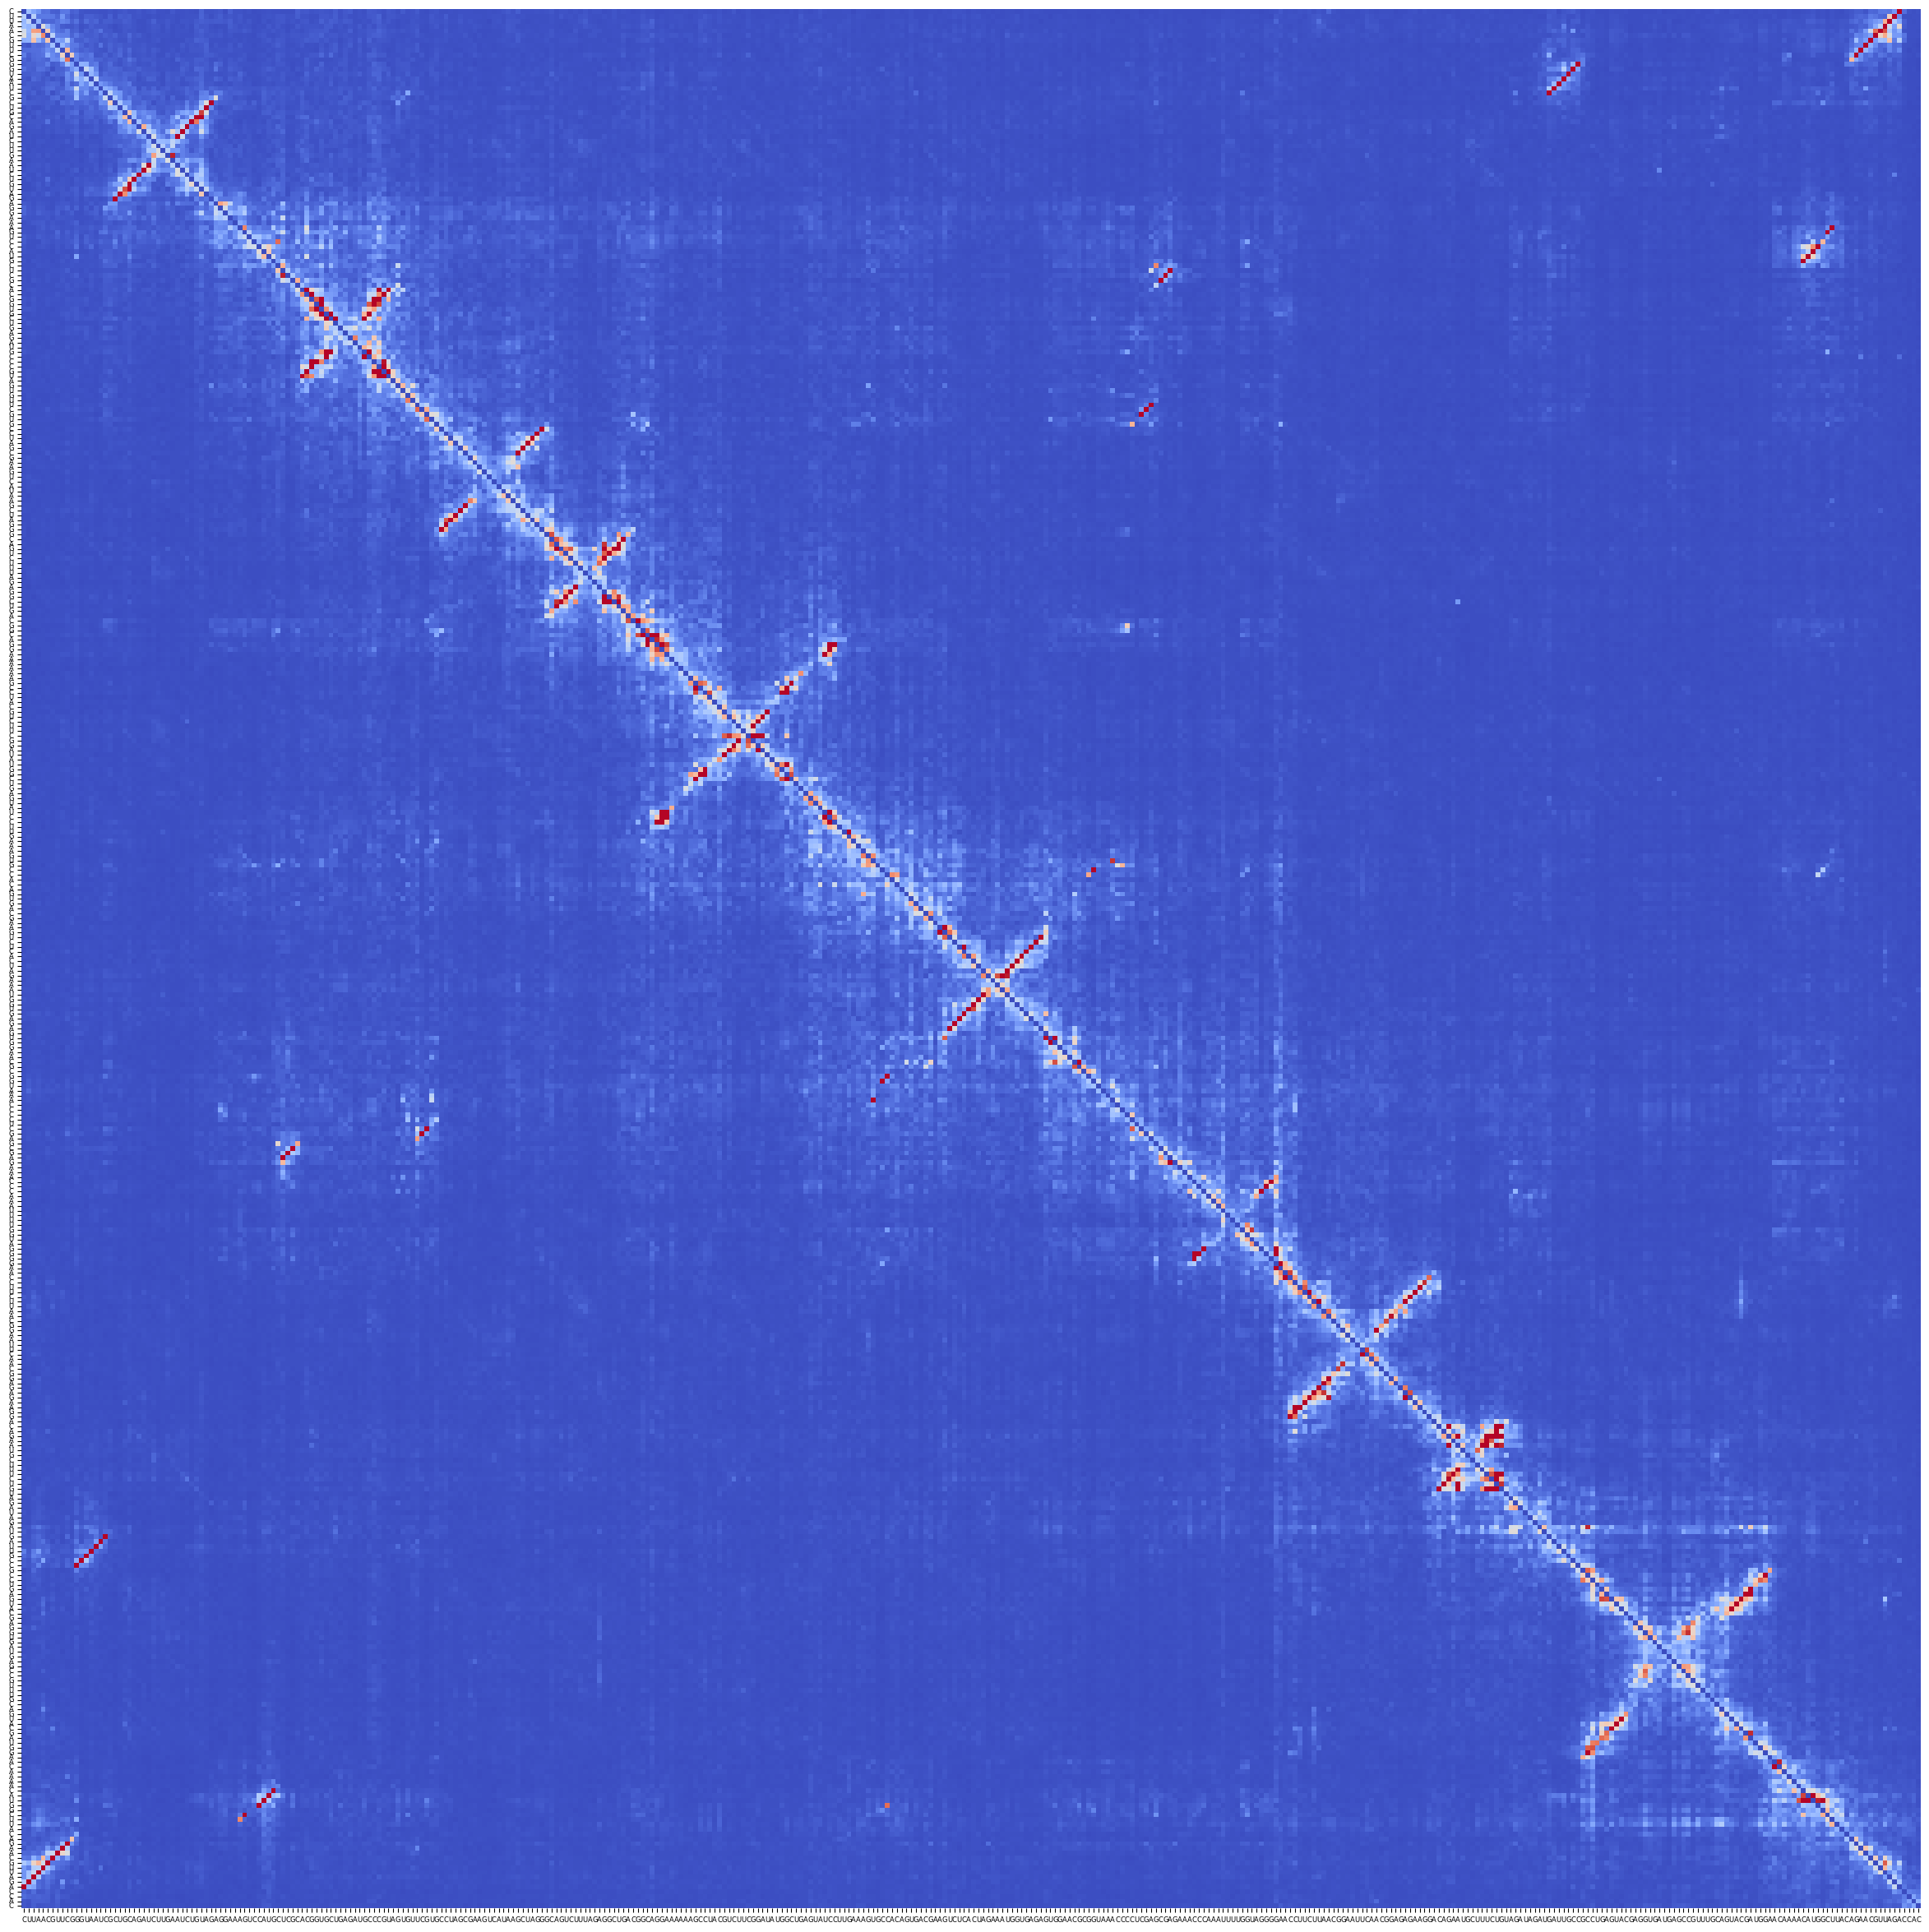

In [97]:
plot_w_seq(ci_matrix, RNA_seq, plot_size=30, tick_label_fontsize=6, filename=None, savefig=False, vmax=7
)

Inferencing 4 batches
Inferencing done


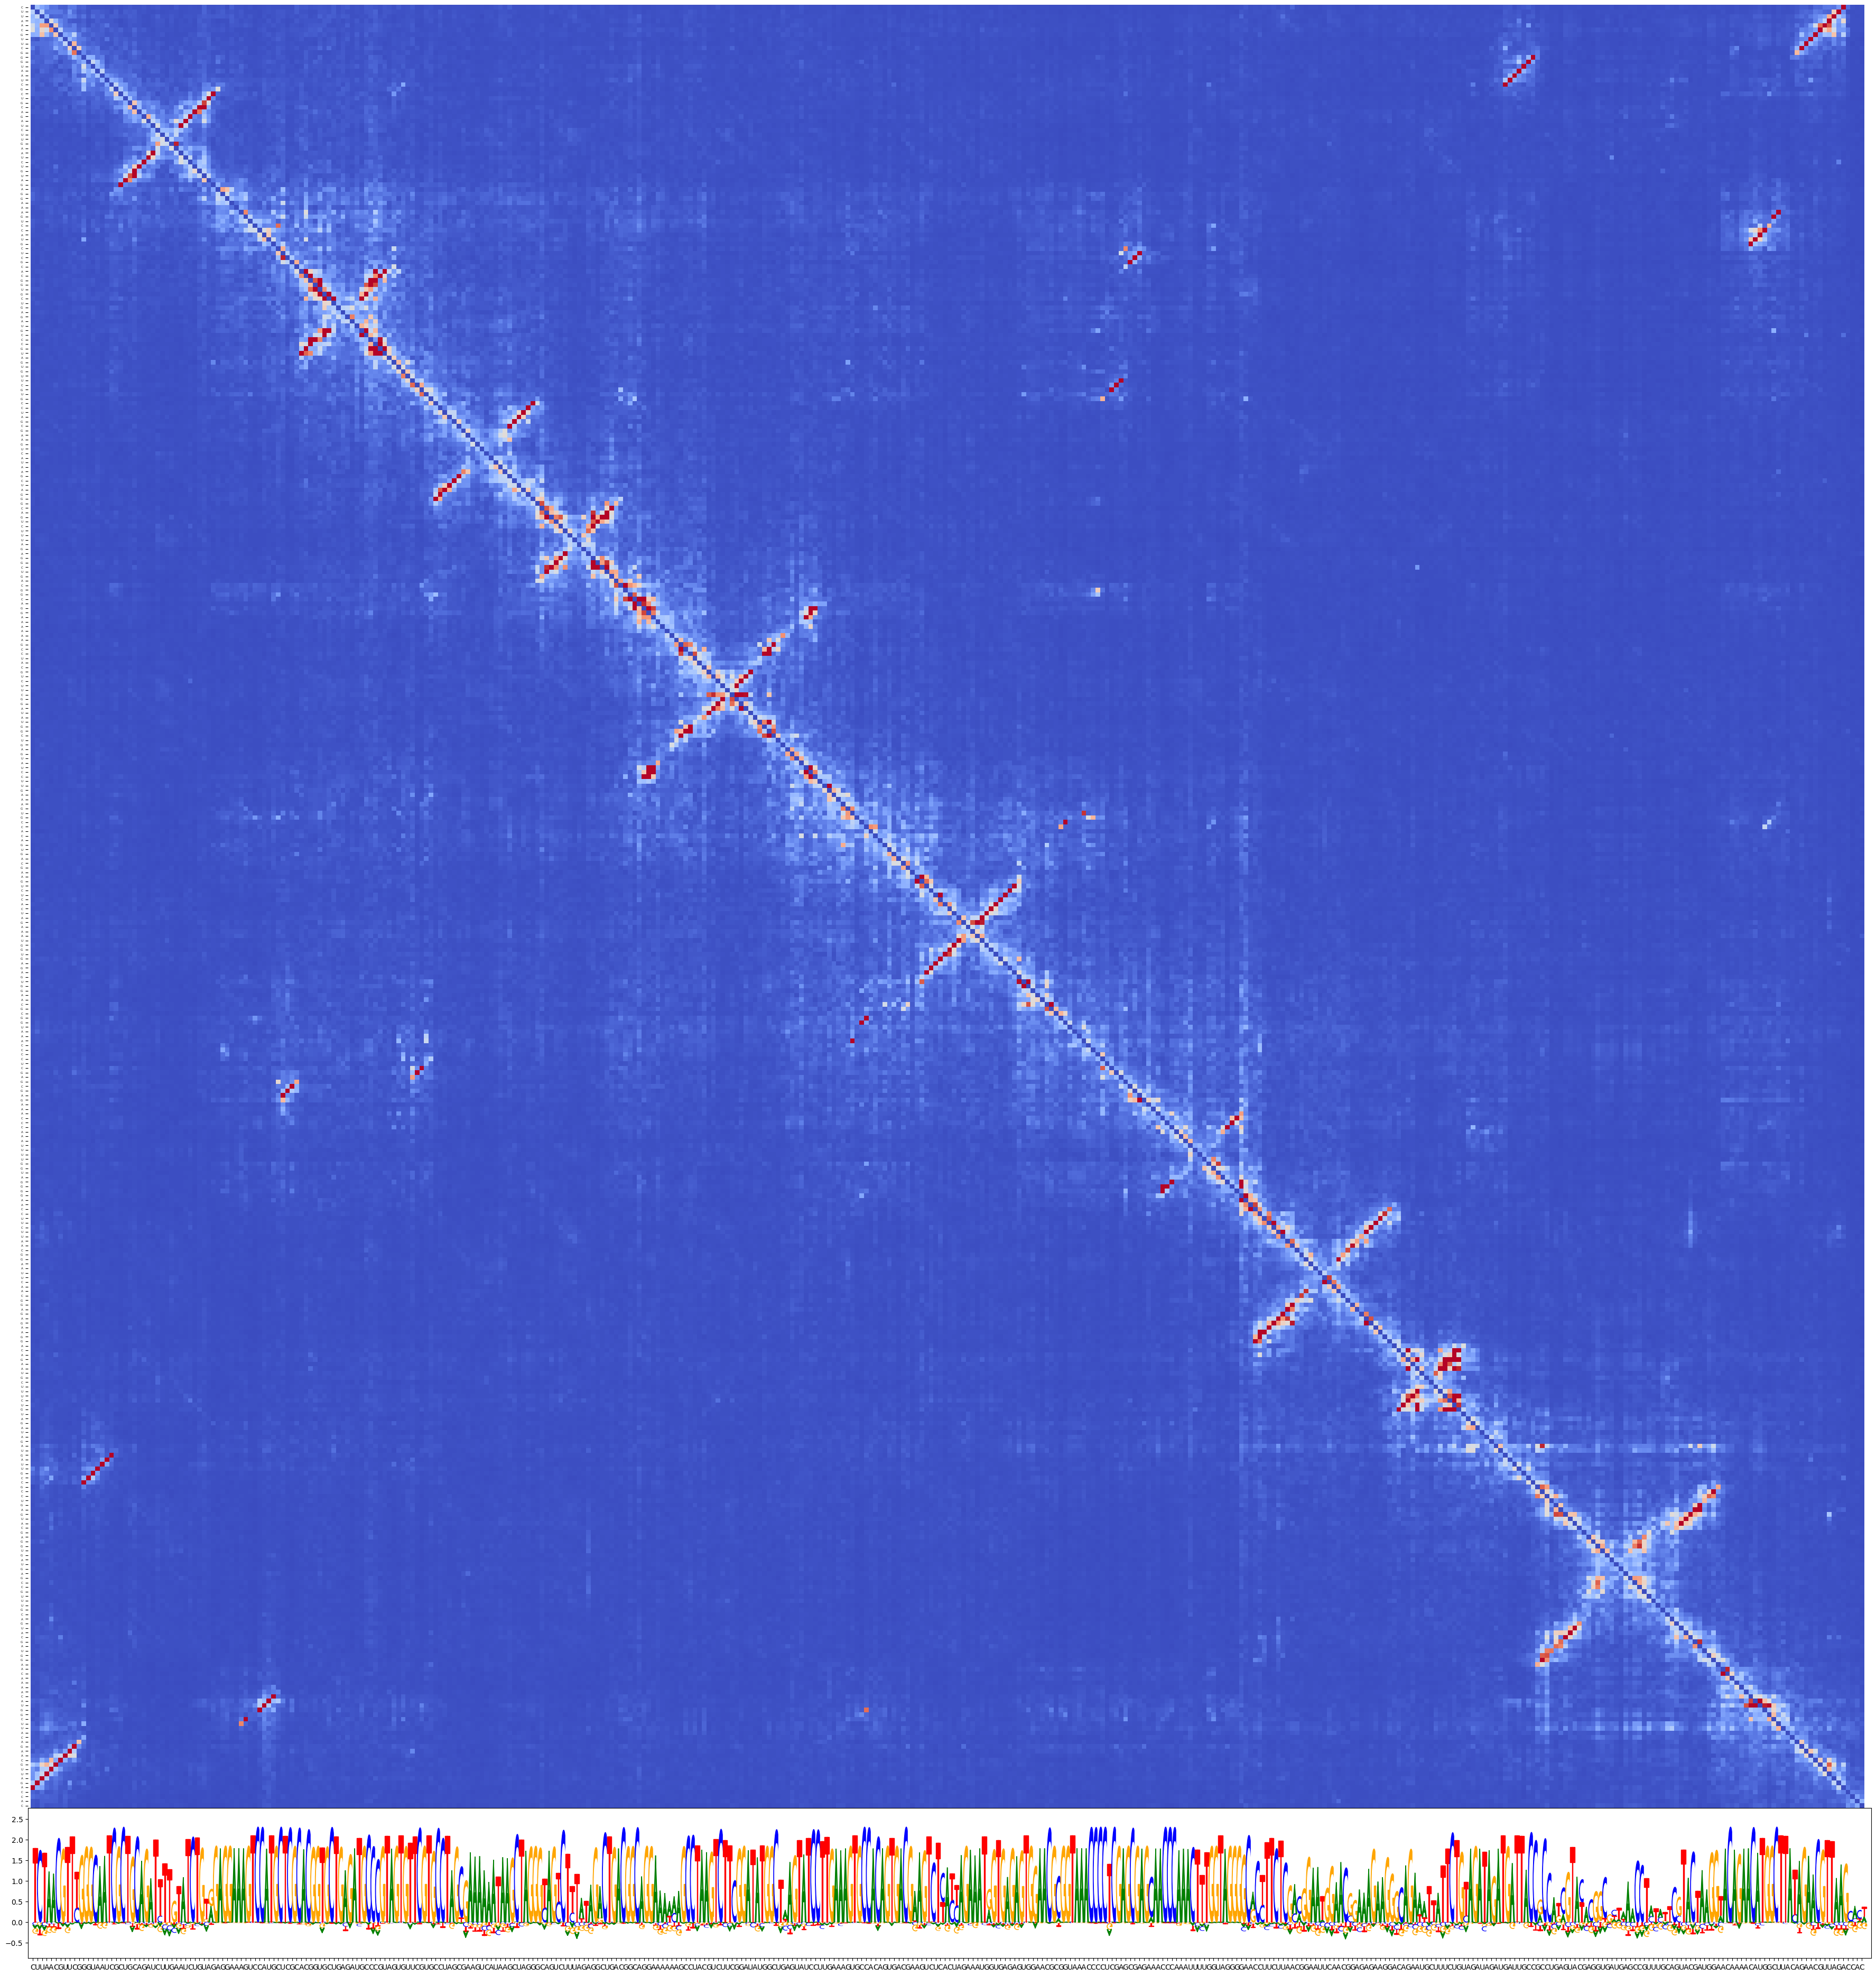

In [99]:
name = 'rnase_p_b_subtilis_168'

# Process the whole sequence at once if it's shorter than the chunk size
filename = os.path.join(project_path, f"ci_matrices/data/incarnato_structs/{name}_dependency_map_w_reconstruction.png")

probs = model_inference_probs(RNA_seq, batch_size=128)
combined_plot(probs, ci_matrix, RNA_seq, figsize=(45, 48), tick_label_fontsize=4, vmax=7, filename=filename, savefig=True, show_plot=True)

## Cobalamin

In [ ]:
'CUGUAGCAUCCACUUGCCGGUCCUGUGAGUUAAUAGGGAAUCCAGUGCGAAUCUGGAGCUGACGCGCAGCGGUAAGGAAAGGUGCGAUGAUUGCGUUAUGCGGACACUCGCCAUUCGGUGGGAAGUCAUCAUCUCUUAGUAUCUUAGAUACCCCUCCAAGCCCGAAGACCUGCCGGCCAACGUCGCAUCUG'

In [35]:
# Cobalamin Ecoli
RNA_seq = '''CUGUAGCAUCCACUUGCCGGUCCUGUGAGUUAAUAGGGAAUCCAGUGCGAAUCUGGAGCUGACGCGCAGCGGUAAGGAAA
GGUGCGAUGAUUGCGUUAUGCGGACACUGCCAUCCGGUGGGAAGUCAUCAUCUCUUAGUAUCUUAGAUACCCCUCCAAGC
CCGAAGACCUGCCGGCCAACGUCGCAUCUGG'''.replace('\n', '')
RNA_seq

'CUGUAGCAUCCACUUGCCGGUCCUGUGAGUUAAUAGGGAAUCCAGUGCGAAUCUGGAGCUGACGCGCAGCGGUAAGGAAAGGUGCGAUGAUUGCGUUAUGCGGACACUGCCAUCCGGUGGGAAGUCAUCAUCUCUUAGUAUCUUAGAUACCCCUCCAAGCCCGAAGACCUGCCGGCCAACGUCGCAUCUGG'

In [36]:
ci_matrix = compute_ci_matrix(RNA_seq)
ci_matrix

Inferencing 9 batches
Inferencing done
(574, 191, 4)
shape of the reference probs: (191, 4)


array([[4.09323645, 0.61762971, 0.12031364, ..., 0.08216301, 0.07623748,
        0.11444449],
       [0.46445167, 4.1597023 , 0.92327958, ..., 0.26158154, 0.09008753,
        0.16514367],
       [0.21556923, 0.72725022, 4.09249401, ..., 0.06762634, 0.10528979,
        0.08373362],
       ...,
       [0.14921355, 0.30622095, 0.0716401 , ..., 4.37127829, 1.24500978,
        0.69590515],
       [0.13012898, 0.15250835, 0.04080263, ..., 1.22724962, 3.94651341,
        1.01816726],
       [0.11763108, 0.11450964, 0.06530359, ..., 0.28814319, 0.80787718,
        4.11631203]])

In [37]:
ci_matrix[np.arange(ci_matrix.shape[0]), np.arange(ci_matrix.shape[1])] = 0

Sequence length: 191


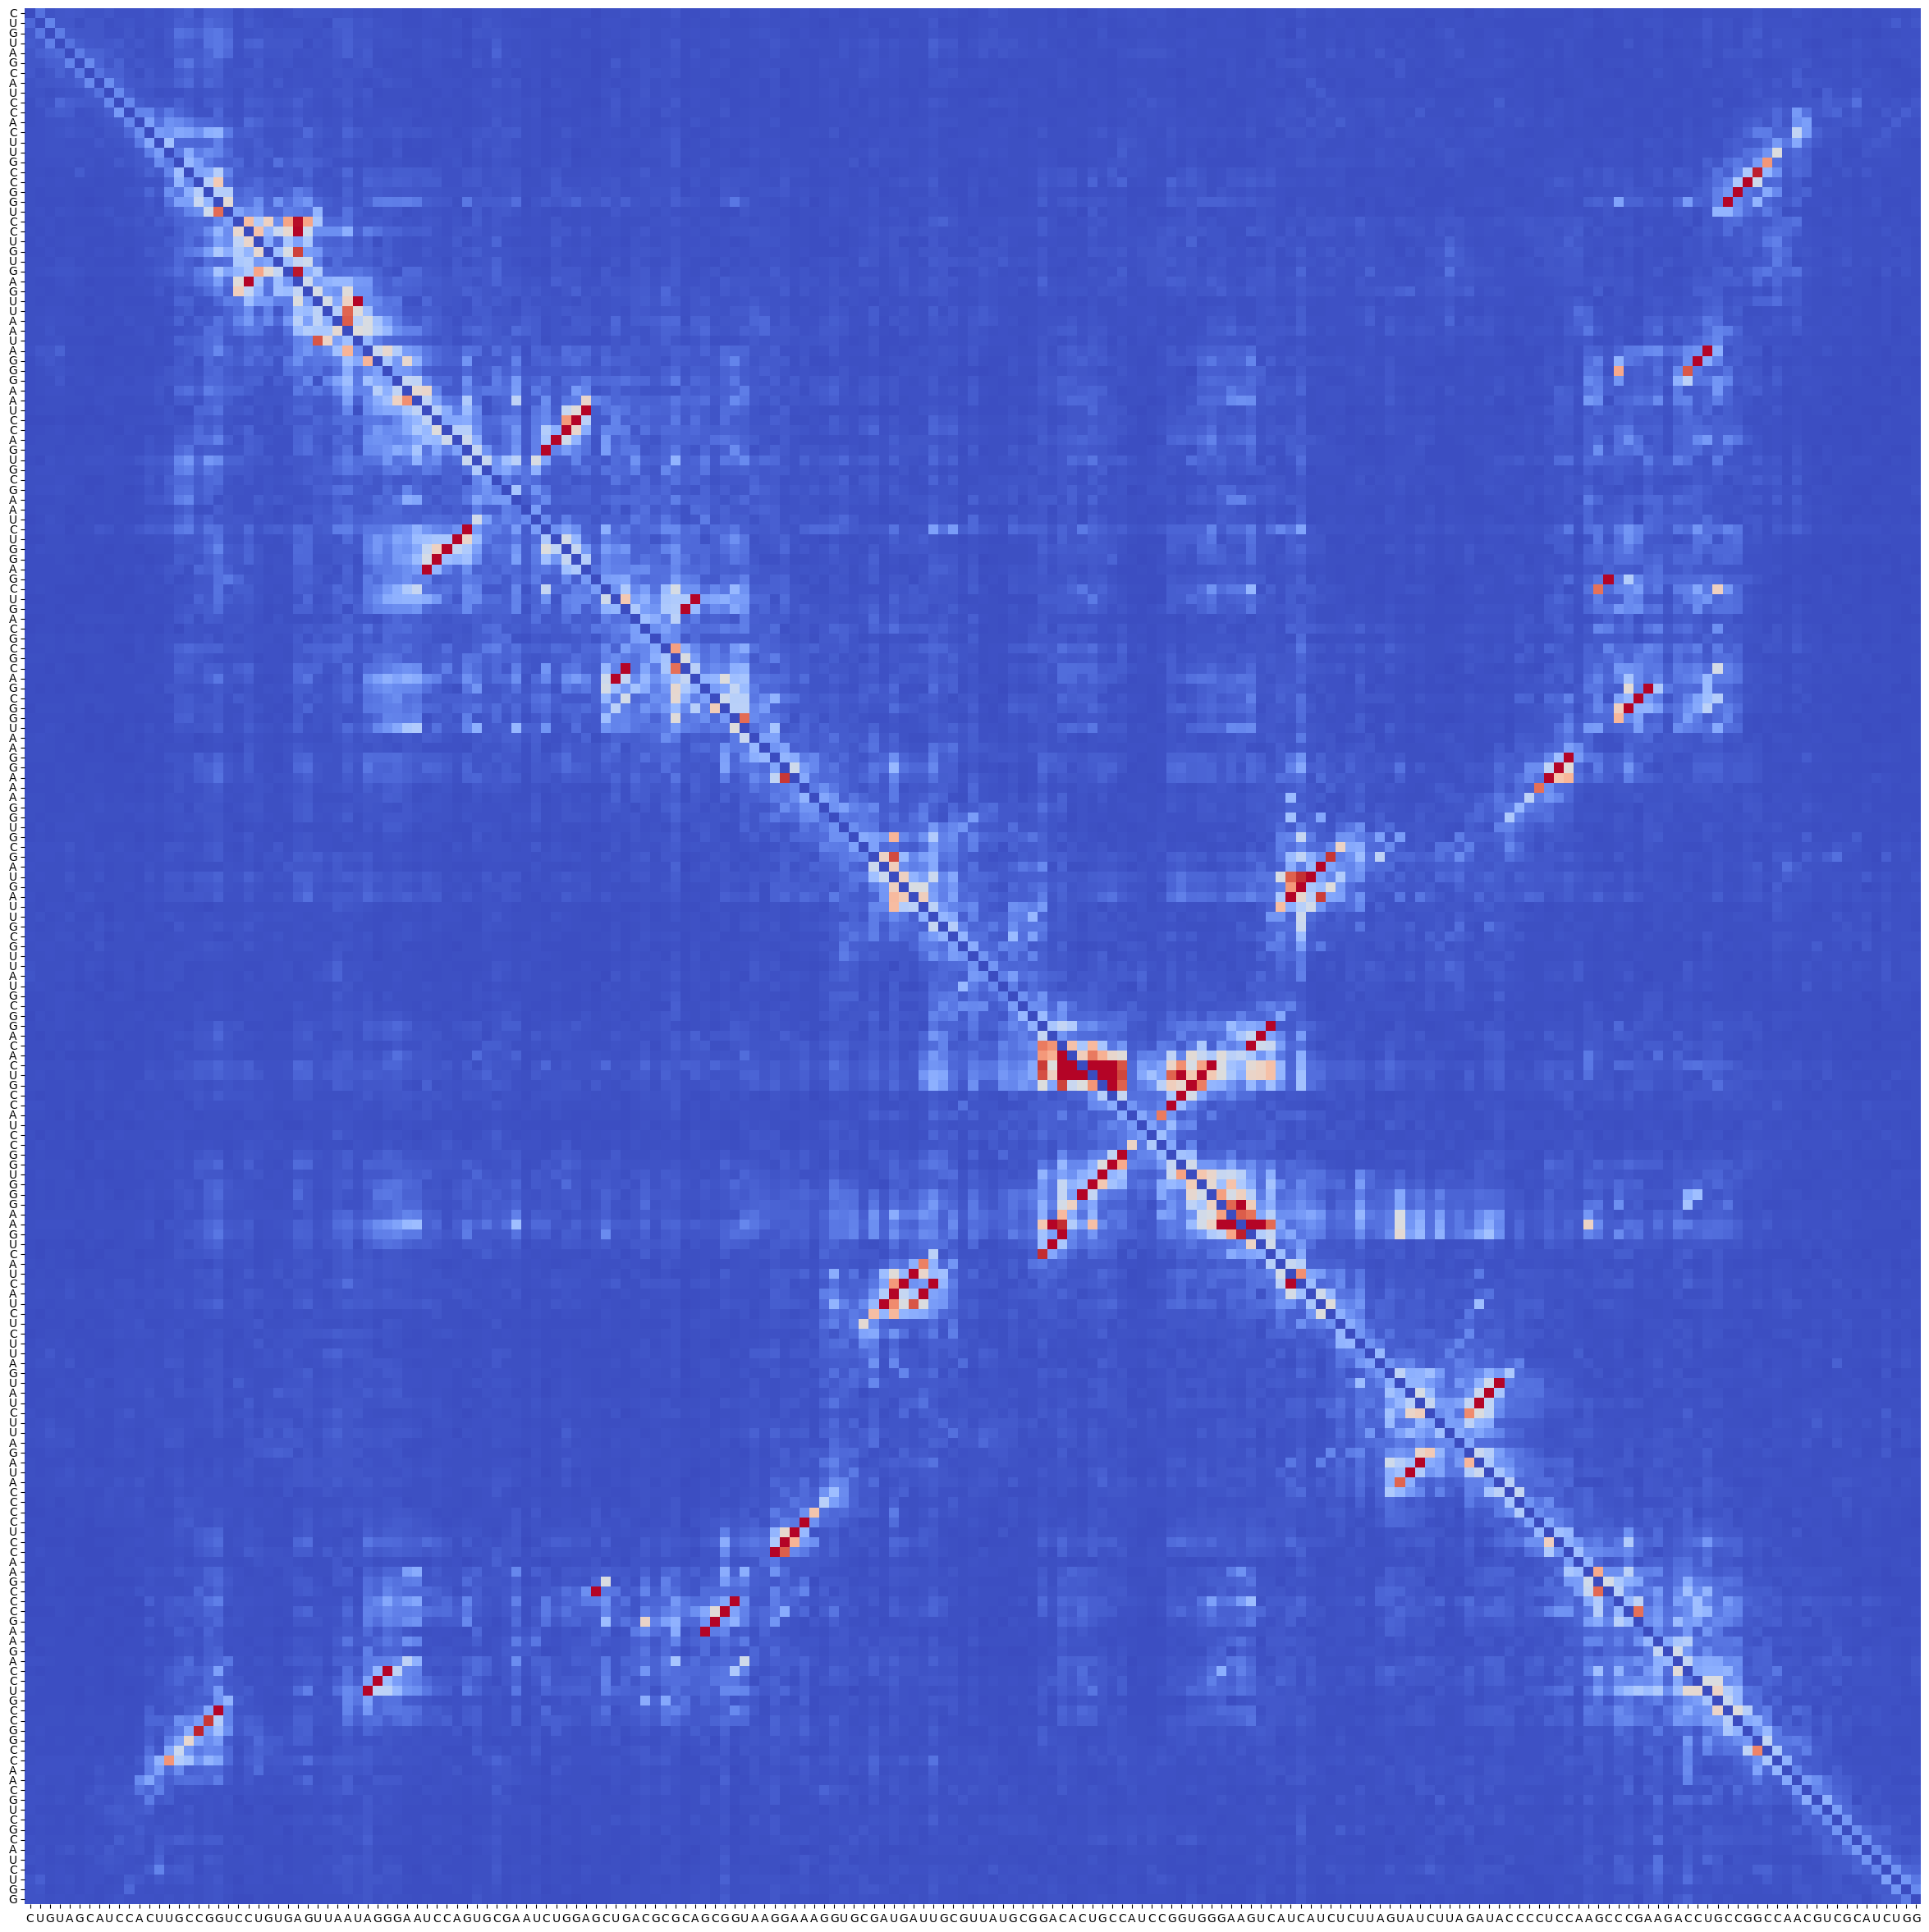

In [38]:
plot_w_seq(ci_matrix, RNA_seq, plot_size=30, tick_label_fontsize=10, filename=None, savefig=False, vmax=7
)